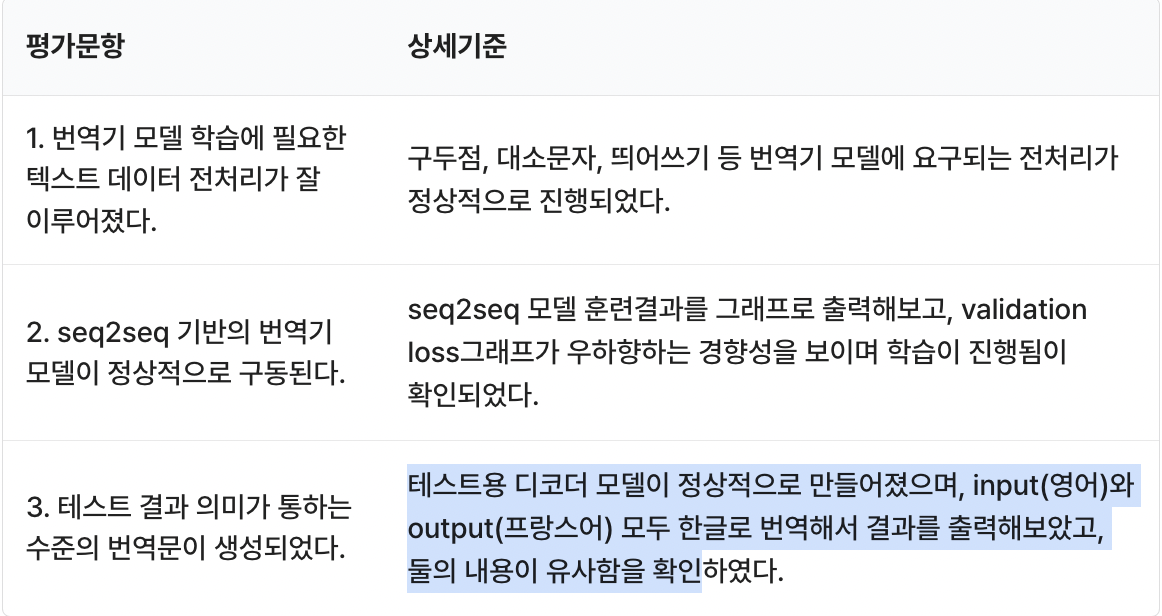

In [1]:
import os
import numpy as np
import pandas as pd
import re

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

In [24]:
lines.tail()

,eng,fra,cc
208901,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
208902,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
208903,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
208904,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
208905,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [9]:
print('전체 샘플의 수 :',len(lines))
lines.sample(n=5, random_state=None) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
67058,I really don't envy you.,Je ne t'envie vraiment pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
171997,Is he really the man you're looking for?,Est-ce vraiment l'homme que vous cherchez ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
145276,This pair of shoes doesn't fit me.,Ces chaussures ne me vont pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
171486,I told her to quickly finish the report.,Je lui ai dit de finir rapidement son rapport.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
73870,How would you do the job?,Comment feriez-vous ce travail ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
# 빌런이였다.
lines = lines[['eng', 'fra']][-33000:] # 3.3만개 샘플 사용
len(lines)

33000

In [3]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
len(lines)

33000

In [5]:
lines.head()

,eng,fra
175906,She had to use her dictionary many times.,Elle dut utiliser son dictionnaire à de nombre...
175907,She has a cold and is absent from school.,Elle a un rhume et est absente de l'école.
175908,She has been absent since last Wednesday.,Elle est absente depuis mercredi dernier.
175909,She has some beautiful antique furniture.,Elle a quelques beaux meubles anciens.
175910,She has the big room entirely to herself.,Elle a cette grande chambre entièrement pour e...


# Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

1. (Punctuation)을 단어와 분리
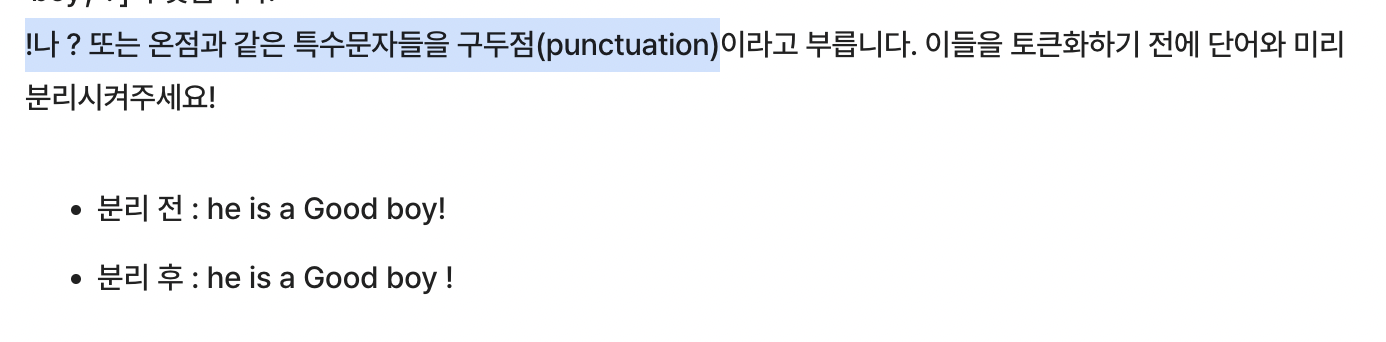
2. 소문자로 
3. 띄어쓰기 단위로 토큰화

French Punctuation mark
> , . : ; ... ! ? « » = '

https://www.frenchtoday.com/blog/french-grammar/french-punctuation/

from nltk.tokenize import word_tokenize

In [83]:
import string

In [82]:
string.punctuation
# 오.. 지영님 

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
lines['fra'] = lines['fra'].apply(lambda x: re.sub('([~!@#$%^&*()-_=+\|[]{};:,.<>/?«»])', " ", x))
lines['fra'] = lines['fra'].apply(lambda x: x.lower().strip()) # , lines['fra'].any
lines['fra'] = lines['fra'].apply(lambda x: '<sos> ' + x + ' <eos>')

In [5]:
lines.head()

,eng,fra
175906,She had to use her dictionary many times.,<sos> elle dut utiliser son dictionnaire à de ...
175907,She has a cold and is absent from school.,<sos> elle a un rhume et est absente de l'écol...
175908,She has been absent since last Wednesday.,<sos> elle est absente depuis mercredi dernier...
175909,She has some beautiful antique furniture.,<sos> elle a quelques beaux meubles anciens. <...
175910,She has the big room entirely to herself.,<sos> elle a cette grande chambre entièrement ...


10,-단어를 기억할 수 있는 tokenizer  
이미 문장을 정제했으니 filters가 필요없어 10,-단어에 포함되지 못한 단어는 ''로 바꿀거에요

각각 하나의 단어로 인식을 위해 char_level=False  
각각의 문자 단위로는 True

In [5]:
eng_token = Tokenizer(char_level=False)
# Updates internal vocabulary based on a list of texts.
eng_token.fit_on_texts(lines['eng'])
# Transforms each text in texts to a sequence of integers.
input_text = eng_token.texts_to_sequences(lines['eng'])

In [7]:
len(input_text)
# 33,000

# char_level=True
len(eng_token.word_index)
# 55

# char_level=Flase
len(eng_token.word_index)
# 11,114

len(eng_token.word_index)

17505

In [14]:
input_text[0]

[29, 47, 3, 239, 61, 1168, 91, 986]

In [6]:
fra_token = Tokenizer(char_level=False)
# Updates internal vocabulary based on a list of texts.
fra_token.fit_on_texts(lines['fra'])
# Transforms each text in texts to a sequence of integers.
target_text = fra_token.texts_to_sequences(lines['fra'])

In [11]:
len(fra_token.word_index)

26532

In [15]:
target_text[0]

[2, 39, 3589, 587, 42, 1016, 8, 4, 488, 1, 3]

In [7]:
eng_vocab_size = len(eng_token.word_index) + 1
fra_vocab_size = len(fra_token.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
# 0번 토큰(padding이 있다고??)을 고려하여 +1을 하고 저장

영어 단어장의 크기 : 4744
프랑스어 단어장의 크기 : 9938


---

In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
# len([29, 47, 3, 239, 61, 1168, 91, 986])
max_fra_seq_len = max([len(line) for line in target_text])
# len([2, 39, 3589, 587, 42, 1016, 8, 4, 488, 1, 3])

In [9]:
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 14


fra_token.word_index
> {`'<unk>'`: 1,
 `'<sos>'`: 2,
> `'<eos>'`: 3,

In [11]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_token.word_index['eos'] ] for line in target_text] 

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_token.word_index['sos'] ] for line in target_text]

In [26]:
len(encoder_input), len(decoder_input), len(decoder_target)

(33000, 33000, 33000)

In [12]:
encoder_input = pad_sequences(encoder_input, 
                              maxlen = max_eng_seq_len, padding='post')

decoder_input = pad_sequences(decoder_input, 
                              maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, 
                               maxlen = max_fra_seq_len, padding='post')

In [13]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 14)
프랑스어 출력데이터의 크기(shape) : (33000, 14)


In [14]:
encoder_input[0], decoder_input[0], decoder_target[0]

(array([21,  0,  0,  0,  0,  0], dtype=int32),
 array([ 1, 58,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int32),
 array([58,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int32))

33,000개 중 3,000개는 테스트 데이터로 분리하여 모델을 학습한 후에  
번역을 테스트 하는 용도로 사용  

In [26]:
len(encoder_input), len(decoder_input), len(decoder_target)

(33000, 33000, 33000)

In [39]:
np.random.randint(0, 33000) # 중복이 생기겠넹

3280

### Examples
> arr = np.arange(10)  
> np.random.shuffle(arr)  
> arr  
[1 7 5 2 9 4 3 6 0 8] # random

In [15]:
array = np.arange(32999)
np.random.shuffle(array)

In [16]:
array

array([ 4255,  4008, 17946, ..., 17742, 30012, 12584])

In [17]:
encoder_input = encoder_input[array]
decoder_input = decoder_input[array]
decoder_target = decoder_target[array]

In [18]:
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (32999, 6)
프랑스어 학습 입력데이터의 크기(shape) : (32999, 14)
프랑스어 학습 출력데이터의 크기(shape) : (32999, 14)


In [19]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [20]:
encoder_input_train.shape,\
decoder_input_train.shape,\
decoder_target_train.shape

((29999, 6), (29999, 14), (29999, 14))

In [21]:
encoder_input_test.shape,\
decoder_input_test.shape,\
decoder_target_test.shape

((3000, 6), (3000, 14), (3000, 14))

# Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

글자 단위 번역기를 구현할 때와 마찬가지로  
디코더의 입력 시퀀스 맨 앞에는 `시작 토큰인 <sos>`가 필요  
그리고 Teacher Forcing를 수행할 때,  
디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는  
`종료 토큰 <eos>`가 필요합니다.

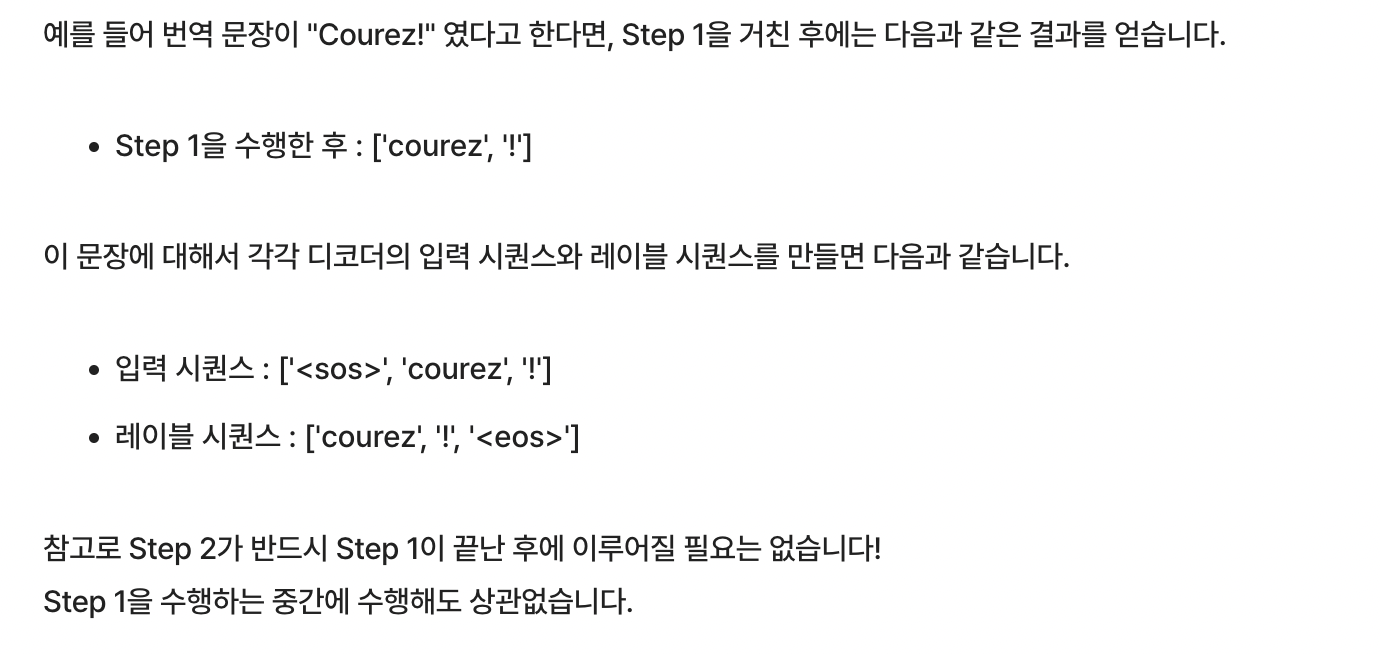

# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

딥러닝 모델은 텍스트가 아닌 숫자를 처리합니다.  
케라스 tokenizer를 사용해서 각 단어를 고유한 정수로 바꿔보세요.  
https://wikidocs.net/31766  
tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

# Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.  
https://wikidocs.net/33793

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,  
디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다! 

In [22]:
vector_dim = 512 # 임베딩 벡터의 차원
hidden_size = 512 # hidden state의 크기
eng_vocab_size # 단어장의 크기

4744

`Embedding(vocab_size, output_dim, input_length=input_length)` 
input_length = 입력 시퀀스의 길이입니다.  
> 만약 갖고있는 `각 샘플의 길이가 500개`이라면 이 값은 `500`
https://wikidocs.net/33793

In [23]:
eng_vocab_size, max_eng_seq_len

(4744, 6)

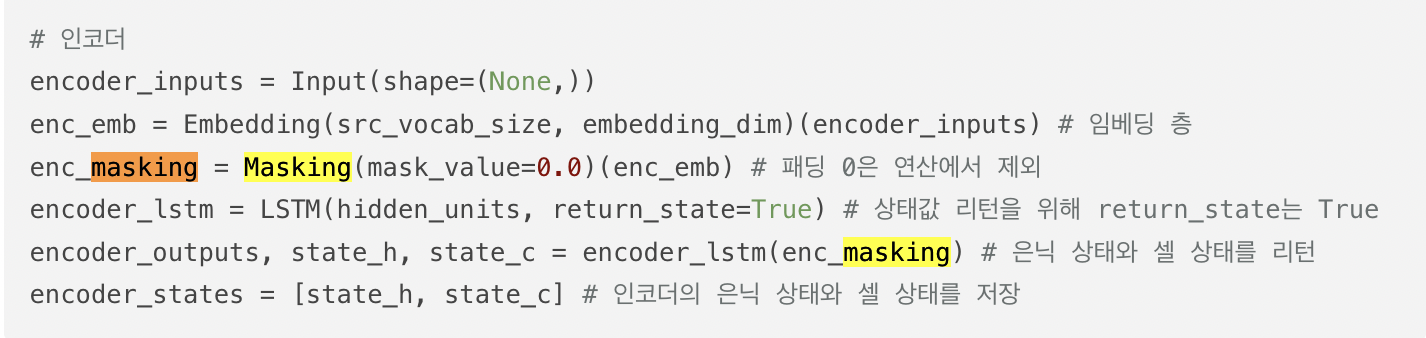
https://wikidocs.net/86900  

In [24]:
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, vector_dim,
                     input_length=max_eng_seq_len)(encoder_inputs)

enc_masking = Masking(mask_value=0.0)(enc_emb)

encoder_lstm = LSTM(hidden_size, dropout=0.3, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

encoder_states = [state_h, state_c]

In [25]:
fra_vocab_size, max_fra_seq_len

(9938, 14)

In [93]:
encoder_states

[<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'lstm')>]

In [26]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, ))

dec_emb = Embedding(fra_vocab_size, vector_dim, 
                    input_length=max_fra_seq_len)(decoder_inputs)

dec_masking = Masking(mask_value=0.0)(dec_emb)

decoder_lstm = LSTM(hidden_size, dropout=0.2, 
                    return_sequences = True, 
                    return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_masking, 
                                    initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# Step 5. 모델 구현하기

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!  

이때는 label이 integer 값이므로 categorical entropy loss가 아닌  
sparse categorical entropy loss를 사용합니다.

In [27]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00099), 
              loss="sparse_categorical_crossentropy",
             metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2428928     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    5088256     input_2[0][0]                    
______________________________________________________________________________________________

In [21]:
ls

best_model.h5             translate-Copy1.ipynb  Translator-Copy1.ipynb
checkpoint                translate-Copy2.ipynb  Translator-Copy2.ipynb
ckpt.data-00000-of-00001  translate-Copy3.ipynb  Translator.ipynb
ckpt.index                translate.ipynb


In [32]:
dir_path = os.getenv('HOME')+'/aiffel/Interactive PYthon NoteBook/16[17]th week'

In [107]:
model_path = os.path.join(dir_path, "ckpt")

In [108]:
model.save_weights(model_path)

---

In [29]:
es = keras.callbacks.EarlyStopping(patience=3)
mc = keras.callbacks.ModelCheckpoint(filepath="best_model.h5",
                                    save_best_only=True,
                                     save_weights_only=True)

In [30]:
model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=256, epochs=88,
         callbacks=[es, mc])

Epoch 1/88
118/118 [==============================] - 19s 95ms/step - loss: 2.5254 - accuracy: 0.6844 - val_loss: 1.8667 - val_accuracy: 0.7321
Epoch 2/88
118/118 [==============================] - 9s 75ms/step - loss: 1.7241 - accuracy: 0.7475 - val_loss: 1.6675 - val_accuracy: 0.7503
Epoch 3/88
118/118 [==============================] - 9s 76ms/step - loss: 1.5457 - accuracy: 0.7614 - val_loss: 1.5110 - val_accuracy: 0.7711
Epoch 4/88
118/118 [==============================] - 9s 77ms/step - loss: 1.3719 - accuracy: 0.7844 - val_loss: 1.3571 - val_accuracy: 0.7939
Epoch 5/88
118/118 [==============================] - 9s 78ms/step - loss: 1.2154 - accuracy: 0.8026 - val_loss: 1.2479 - val_accuracy: 0.8052
Epoch 6/88
118/118 [==============================] - 9s 79ms/step - loss: 1.0914 - accuracy: 0.8157 - val_loss: 1.1628 - val_accuracy: 0.8164
Epoch 7/88
118/118 [==============================] - 9s 80ms/step - loss: 0.9853 - accuracy: 0.8264 - val_loss: 1.0954 - val_accuracy: 0.826

In [31]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
his_dict = model.history.history

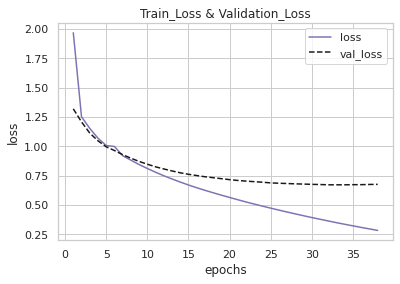

In [31]:
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) +1) 
plt.plot(epochs, loss, "m-", label="loss")
plt.plot(epochs, val_loss, "k--", label="val_loss")

plt.title("Train_Loss & Validation_Loss")
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend()
plt.show()

# 최최최최최종 그래프

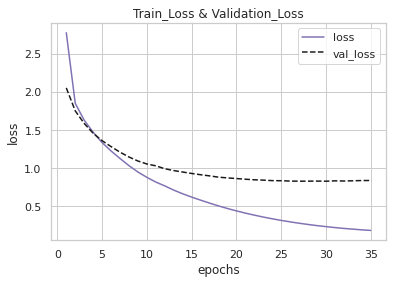

In [27]:
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) +1) 
plt.plot(epochs, loss, "m-", label="loss")
plt.plot(epochs, val_loss, "k--", label="val_loss")

plt.title("Train_Loss & Validation_Loss")
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend()
plt.show()

# 최최최최ㅗ치ㅗ치ㅗ치ㅗ치ㅣ치최최초ㅚ최치최ㅗ치ㅗ치최최최최푀최최최ㅚ종이다요

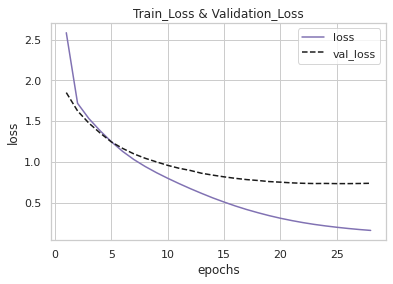

In [23]:
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) +1) 
plt.plot(epochs, loss, "m-", label="loss")
plt.plot(epochs, val_loss, "k--", label="val_loss")

plt.title("Train_Loss & Validation_Loss")
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend()
plt.show()

loss: 0.1606 - val_loss: 0.7382  
끝.

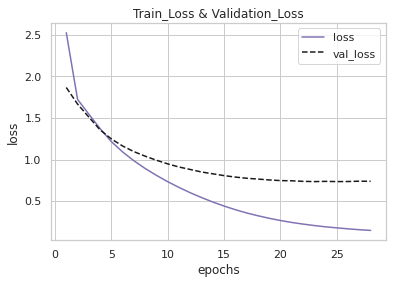

In [33]:
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) +1) 
plt.plot(epochs, loss, "m-", label="loss")
plt.plot(epochs, val_loss, "k--", label="val_loss")

plt.title("Train_Loss & Validation_Loss")
plt.xlabel('epochs')
plt.ylabel("loss")
plt.legend()
plt.show()

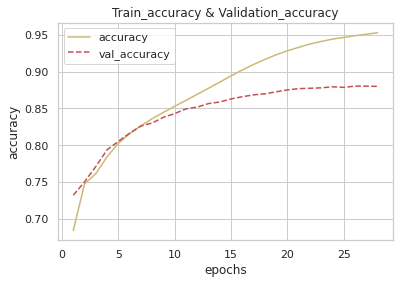

In [35]:
accuracy = his_dict['accuracy']
val_accuracy = his_dict['val_accuracy']
epochs = range(1, len(loss) +1) 
plt.plot(epochs, accuracy, "y-", label="accuracy")
plt.plot(epochs, val_accuracy, "r--", label="val_accuracy")

plt.title("Train_accuracy & Validation_accuracy")
plt.xlabel('epochs')
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Step 6. 모델 평가하기
단어 단위 번역기를 이용하여 훈련 데이터의 샘플과  
테스트 데이터의 샘플로 번역 문장을 만들어보고  
정답 문장과 번역 문장을 비교해보세요.  

이전 스텝들에서 우리가 공부했던 모델의 경우  
글자 단위에서 구현된 번역기이며  
현재 프로젝트를 진행할 때 사용하는 모델은 단어 단위에서 구현되는 번역기입니다.

In [36]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2428928   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 2099200   
Total params: 4,528,128
Trainable params: 4,528,128
Non-trainable params: 0
_________________________________________________________________


In [116]:
decoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_3')>

In [119]:
fra_vocab_size

26533

---

In [37]:
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c = Input(shape=(512,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb = Embedding(fra_vocab_size, 512)(decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, 
                                                 initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [38]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [39]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, 
                      outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 512)    5088256     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

---

In [40]:
eng2idx = eng_token.word_index
fra2idx = fra_token.word_index

idx2eng = eng_token.index_word
idx2fra = fra_token.index_word

fra2idx
>'`<unk>`': 1,
 '`<sos>`': 2,
 '`<eos>`': 3,
> 'de': 4,

In [41]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0,0] = fra2idx['sos']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == 'eos' or
           len(decoded_sentence) > max_fra_seq_len): #decoded_sentece.split()
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [30]:
for seq_index in [500, 555, 1000]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][5:len(lines.fra[seq_index])-5]) 
    # '<sos>'와 '<eos>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) 
    # '<eos>'을 빼고 출력

-----------------------------------
입력 문장: Get away!
정답 문장:  écarte-toi ! 
번역기가 번역한 문장:  je le le le
-----------------------------------
입력 문장: Go ahead!
정답 문장:  poursuivez ! 
번역기가 번역한 문장:  j'aime me
-----------------------------------
입력 문장: He is ill.
정답 문장:  il est malade. 
번역기가 번역한 문장:  tu vous ! 


# 최초치ㅗ치ㅚ최최최최최최ㅚ종

In [34]:
for i in range(10):
    random_index = np.random.randint(1, 32999)
    input_seq = encoder_input[random_index: random_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[random_index])
    print('정답 문장:', lines.fra[random_index][5:len(lines.fra[random_index])-5]) 
    # '<sos>'와 '<eos>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) 
    # '<eos>'을 빼고 출력

-----------------------------------
입력 문장: Please be careful.
정답 문장:  veuillez être prudente. 
번역기가 번역한 문장:  c'est un 
-----------------------------------
입력 문장: Stand aside.
정답 문장:  restez à l'écart. 
번역기가 번역한 문장:  ce n'est 
-----------------------------------
입력 문장: I love bread.
정답 문장:  j'adore le pain. 
번역기가 번역한 문장:  c'est est 
-----------------------------------
입력 문장: Arm yourself.
정답 문장:  armez-vous. 
번역기가 번역한 문장:  je du aujourd
-----------------------------------
입력 문장: Hand me my mug.
정답 문장:  passe-moi mon mug. 
번역기가 번역한 문장:  ce n'était
-----------------------------------
입력 문장: I was insulted.
정답 문장:  j'étais offensé. 
번역기가 번역한 문장:  est-ce cec
-----------------------------------
입력 문장: There's no cure.
정답 문장:  il n'y a pas de traitement. 
번역기가 번역한 문장:  c'était était 
-----------------------------------
입력 문장: Be seated.
정답 문장:  asseyez-vous. 
번역기가 번역한 문장:  il il de mainte
-----------------------------------
입력 문장: Do I need this?
정답 문장:  ai-je besoin de ça ? 
번역기가 번역한 문장:  pe

# 최최최최초ㅚ초치치ㅚㅚ최최초치ㅗ치최ㅗㅊ치ㅗ치ㅗ치ㅚ최최최초ㅗ치ㅗ치ㅗ치ㅗ치ㅚ최최종이다유

In [31]:
for i in range(10):
    random_index = np.random.randint(1, 32999)
    input_seq = encoder_input[random_index: random_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[random_index])
    print('정답 문장:', lines.fra[random_index][5:len(lines.fra[random_index])-5]) 
    # '<sos>'와 '<eos>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) 
    # '<eos>'을 빼고 출력

-----------------------------------
입력 문장: Tom flinched.
정답 문장:  tom a bronché. 
번역기가 번역한 문장:  personne 
-----------------------------------
입력 문장: Go ahead.
정답 문장:  allez ! 
번역기가 번역한 문장:  il le le l
-----------------------------------
입력 문장: Tom voted.
정답 문장:  tom a voté. 
번역기가 번역한 문장:  je me me 
-----------------------------------
입력 문장: Don't look for us.
정답 문장:  ne nous cherchez pas ! 
번역기가 번역한 문장:  qui qui ? 
-----------------------------------
입력 문장: He went by bicycle.
정답 문장:  il est parti en vélo. 
번역기가 번역한 문장:  tom tom to
-----------------------------------
입력 문장: Let's have dinner.
정답 문장:  allons dîner. 
번역기가 번역한 문장:  soyez soye
-----------------------------------
입력 문장: The soup's cold.
정답 문장:  le potage est froid. 
번역기가 번역한 문장:  le le le ? 
-----------------------------------
입력 문장: What can Tom do?
정답 문장:  que peut bien faire tom ? 
번역기가 번역한 문장:  nous de du
-----------------------------------
입력 문장: None of us saw it.
정답 문장:  aucun de nous ne l'a vue. 
번역기가 번역한 문장:  il il 

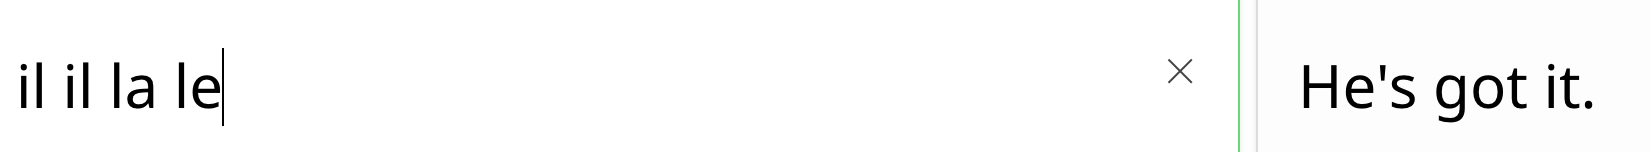

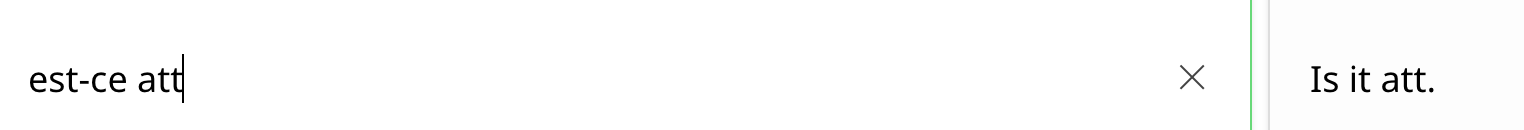

---

예측 실패 꾸웨에에엑

In [48]:
for i in range(10):
    random_index = np.random.randint(1, 32999)
    input_seq = encoder_input[random_index: random_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[random_index])
    print('정답 문장:', lines.fra[random_index][5:-5]) 
    # '<sos>'와 '<eos>'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence) 
    # '<eos>'을 빼고 출력

-----------------------------------
입력 문장: He sells cars.
정답 문장:  il vend des voitures. 
번역기가 번역한 문장:  elle les les eos
-----------------------------------
입력 문장: Loosen up.
정답 문장:  détendez-vous ! 
번역기가 번역한 문장:  c'est est mon eos
-----------------------------------
입력 문장: Tom doesn't smoke.
정답 문장:  tom ne fume pas. 
번역기가 번역한 문장:  ça ça eos
-----------------------------------
입력 문장: That isn't mine.
정답 문장:  ce n'est pas la mienne. 
번역기가 번역한 문장:  peux tu tu la eos
-----------------------------------
입력 문장: I'm exhausted.
정답 문장:  je suis vannée. 
번역기가 번역한 문장:  il très une eos
-----------------------------------
입력 문장: We're here.
정답 문장:  nous sommes ici. 
번역기가 번역한 문장:  puis je je eos
-----------------------------------
입력 문장: Behave like a man.
정답 문장:  conduisez-vous comme un homme. 
번역기가 번역한 문장:  mange quelque eos
-----------------------------------
입력 문장: You can have both.
정답 문장:  tu peux avoir les deux. 
번역기가 번역한 문장:  tom tom à eos
-----------------------------------
입력 문장: I'm thril

# 회고

### 과정
1. 영어 & 프랑스어 모두 정제 정규화 전처리를 하네요
> Punctuation, lowercase, token 띄어쓰기 단위로

2. Decoder sentence에 <Start, <End token 넣어주기
    
3. tokenizer.texts_to_sequences()를 통해서 text -> integer로 변환

4. to_categorical 함수 대신 Embedding Layer를 사용하기

5. model layer 쌓기

6. 번역을 잘 했는지 확인하기

loss를 줄여도 번역기가 딴 소리한다.  
조금 더 정제 과정을 더 잘 거치고 loss를 0에 근접하게 만들어야 좋은 결과가 생길까?  
layer에 masking & dropout을 넣어서 skip하는 과정을 통해 조금 더 좋은 결과가 있을 것이란 기대감은 배신을 당했다.  
무엇보다도 lines를 자를 때 거꾸로 자르지 마라.(자를 거면 차라리 208,904 다 써라)   
나 처럼 처음부터 다시 하게 될 것이다.  

설마...단어장의 크기를 조절하면 달라지나?! 너무 컸나?? 크기 때문에 계산할 것도 많아서?! -> 그건 아니였다.  
번역 출력하는 코드 수정하면 달라지나?!  --> 이것 또한 아니였다.
그렇다.  
나는 루저다.  

    그래프 그리면서 느끼는 부분이지만 accuracy가 없었다. accuracy가 높아도 좋은 결과를 도출은 안하기에 뺀 것인가? 그저 추측만 한다.  

---
설마...  
영어 단어장의 크기 : 6916  
프랑스어 단어장의 크기 : 13452  
영어 시퀀스의 최대 길이 47  
프랑스어 시퀀스의 최대 길이 57  

--- 
최종...  
영어 단어장의 크기 : 4744  
프랑스어 단어장의 크기 : 9938  
영어 시퀀스의 최대 길이 6  
프랑스어 시퀀스의 최대 길이 14  

에러 폭탄
---

In [21]:
lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   eng     33000 non-null  object
 1   fra     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


KeyError: 32999 & AttributeError: 'int' object has no attribute 'assign'의 근본적인 원인은  
-> lines = lines[['eng', 'fra']][-33000:] 거꾸로 잘랐기 때문이다. 

lines.eng[175,906:208,904] 이 범위 안에 존재한다.  
encoder_input[:32,999] 이 범위 안에 존재한다.  
그래서 한쪽을 맞추면 KeyError, 다른 한쪽을 맞추면 AttributeError가 나왔다.  
하...


In [48]:
lines['eng']

175906            She had to use her dictionary many times.
175907            She has a cold and is absent from school.
175908            She has been absent since last Wednesday.
175909            She has some beautiful antique furniture.
175910            She has the big room entirely to herself.
                                ...                        
208901    A carbon footprint is the amount of carbon dio...
208902    Death is something that we're often discourage...
208903    Since there are usually multiple websites on a...
208904    If someone who doesn't know your background sa...
208905    It may be impossible to get a completely error...
Name: eng, Length: 33000, dtype: object

In [52]:
decode_sequence

<function __main__.decode_sequence(input_seq)>

In [56]:
print('입력 문장:', lines.eng[175906])

입력 문장: She had to use her dictionary many times.


In [62]:
print('정답 문장:', lines.fra[seq_index][5:len(lines.fra[seq_index])-5])

정답 문장:  elle dut utiliser son dictionnaire à de nombreuses reprises. 


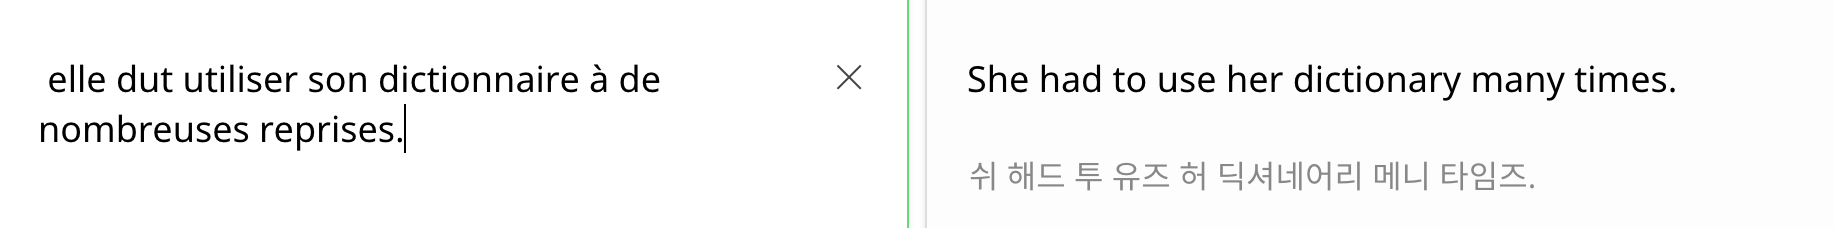

In [55]:
print('번역기가 번역한 문장:', decode_sequence(input_seq)[:-5])

번역기가 번역한 문장:  je je juste juste mais mais mais à à à de de ? ? ? ? ? 


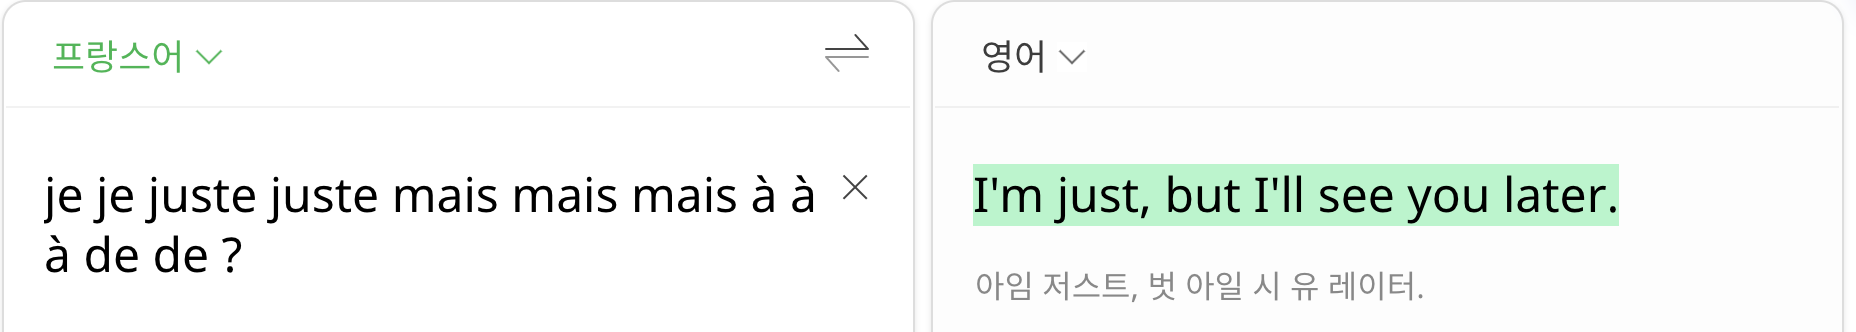

In [63]:
print('입력 문장:', lines.eng[208904])

입력 문장: If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.


In [64]:
print('정답 문장:', lines.fra[208904][5:len(lines.fra[208904])-5]) 

정답 문장:  si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. en d'autres termes, vous ne parlez pas vraiment comme un locuteur natif. 


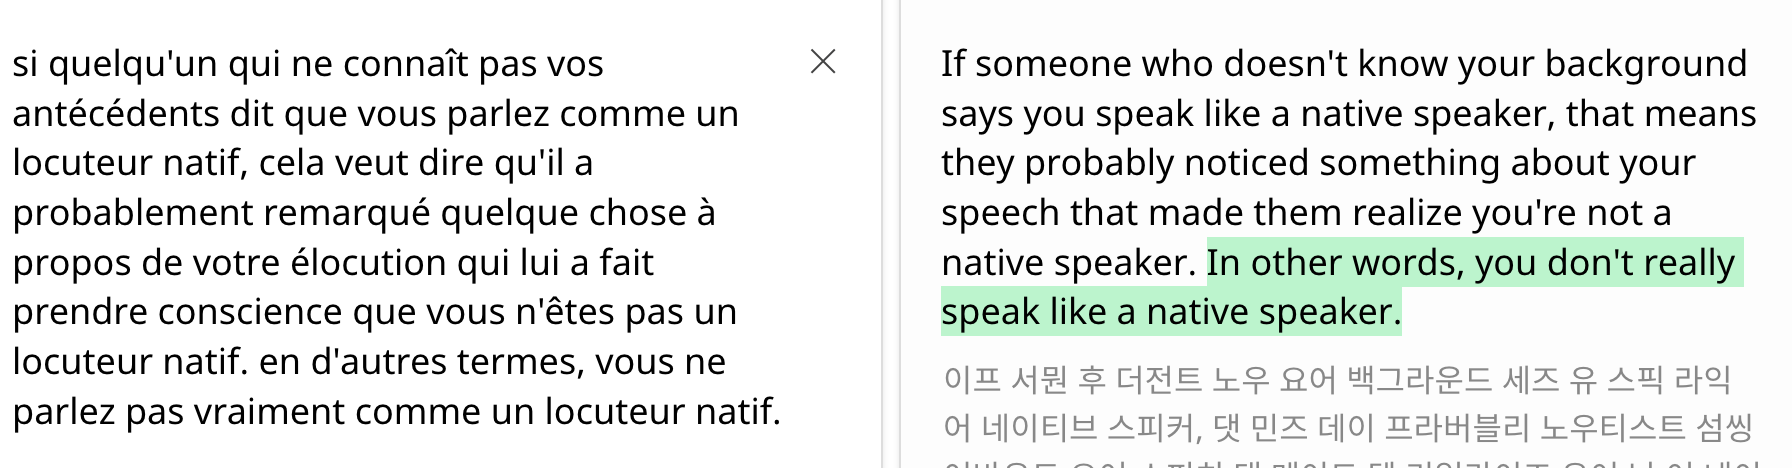

In [ ]:
print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) 

In [65]:
input_seq = encoder_input[208904: 208904+1]

In [84]:
lines.fra[32999]

KeyError: 32999

In [83]:
encoder_input[32999]

array([   5,   80,  979,    2,  426,   66,  147, 1249,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [68]:
input_seq

array([], shape=(0, 47), dtype=int32)

In [67]:
decoded_sentence = decode_sequence(input_seq)

AttributeError: 'int' object has no attribute 'assign'

P.S 하... 현타 온다.